# **T05: Learning with Imbalanced Data**

A. Provide a global comparison of solutions in imbalanced learning. To this end, you should start with the baseline performance (select a traditional classifier) and decide which metric(s) to optimize, justifying your decision. Then, select among several undersampling, oversampling, and hybrid methods (i.e., combining both under- and oversampling) and provide a global comparison among the different families and methods. For this purpose you might want to explore imbalanced-learn or smote- variants.


Michał Dawid Kowalski

up202401554

## 1. Imbalanced data generating
Using make_classification function from sklearn to generate syntetic imbalanced binary dataset for future tests.

Dataset features:
- 2000 samples
- Imbalance ratio: 0.5 to 0.95
- Number of features: 3
- Number of classes: 2

In [3]:
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Generating an imbalanced binary classification dataset function
def generate_data(n_samples=2000, n_features=4, n_classes=2, n_informative=3, n_redundant=1, weights=[0.95, 0.05], seed=None):
    X, y = make_classification(
        n_classes=n_classes,          # Num of classes
        class_sep=0.5,                # How distinct the classes are
        weights=weights,              # Imbalance ratio (classes weights)
        n_informative=n_informative,  # Num of informative features
        n_redundant=n_redundant,      # Num of redundant features
        n_features=n_features,        # Num of features
        n_clusters_per_class=1,       # Single cluster per class
        n_samples=n_samples,          # Total number of samples
        random_state=seed
    )
    
    # Converting to DataFrame
    data = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
    data['Target'] = y
    
    # Displaying class distribution
    class_counts = data['Target'].value_counts()
    print("Class Distribution:")
    print(class_counts)

    return data
    
# Data split function 
def split_data(df, str_target):
    X = df.drop(str_target, axis=1)
    y = df[str_target]
    return X, y

# Plotting 
def plot_features(data, feat_x, feat_y, target_col='Target'):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(
        x=feat_x,
        y=feat_y,
        hue=target_col,
        style=target_col,
        data=data,
        palette='coolwarm',
        s=50,
        alpha = 0.5
    )
    plt.title(f'Scatter Plot: {feat_x} vs {feat_y}', fontsize=12)
    plt.xlabel(feat_x, fontsize=10)
    plt.ylabel(feat_y, fontsize=10)
    plt.show()

# Classes distribution
def class_distribution(data, target_col='Target'):

    plt.figure(figsize=(5, 4))
    sns.countplot(x=target_col, data=data, hue=target_col, palette='coolwarm')
    
    class_counts = data[target_col].value_counts()
    for i, count in enumerate(class_counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    plt.title('Class Distribution', fontsize=12)
    plt.xlabel('Class', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [7]:
# Generating a random imbalanced dataset to use it in the experiment
df = generate_data(seed=4)

Class Distribution:
Target
0    1895
1     105
Name: count, dtype: int64


In [9]:
df.head(14) # Dataframe

feat_0    feat_1    feat_2    feat_3  Target
0  -1.893974  0.606302 -0.485873  1.260728       0
1  -0.126885 -2.314044  1.187928 -1.537245       0
2  -1.294855 -1.095365  0.430687 -0.153647       0
3  -0.346458 -0.961316  0.015432  0.048176       0
4   0.216745 -1.051790 -0.222221  0.148449       0
5   0.862279 -1.209818 -0.427531  0.178024       0
6  -1.554034  0.893896 -0.426041  1.088116       0
7  -0.799905  1.735035 -2.387978  3.295279       0
8   2.218703 -0.712258 -2.040994  1.737788       0
9  -2.274494  1.531892 -1.032093  2.106994       0
10 -2.674416  0.544950  0.574925  0.211465       0
11  0.345640 -1.223311 -0.381168  0.292584       0
12 -3.357958  0.589265  0.244750  0.848366       0
13  0.867409  1.939817 -0.628602  0.582500       1

In [11]:
df.info() # DataFrame info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   feat_0  2000 non-null   float64
 1   feat_1  2000 non-null   float64
 2   feat_2  2000 non-null   float64
 3   feat_3  2000 non-null   float64
 4   Target  2000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 78.3 KB


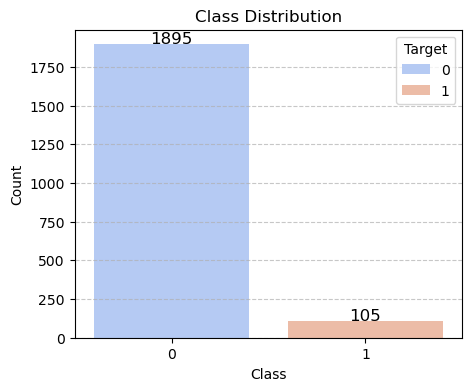

In [13]:
class_distribution(df) # Classes countplot

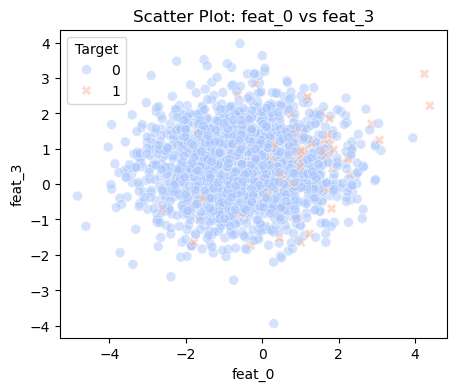

In [15]:
# Redundant feature and informative feature plot
plot_features(df, 'feat_0', 'feat_3')

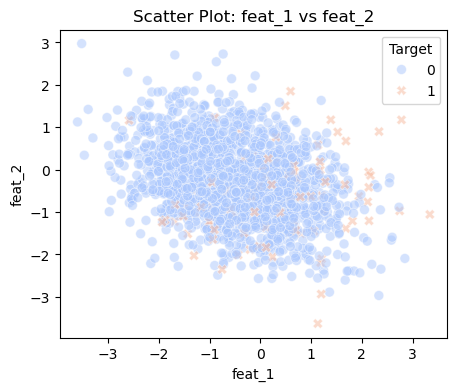

In [17]:
# Classes distribution feat_1 and feat_2
plot_features(df, 'feat_1', 'feat_2')

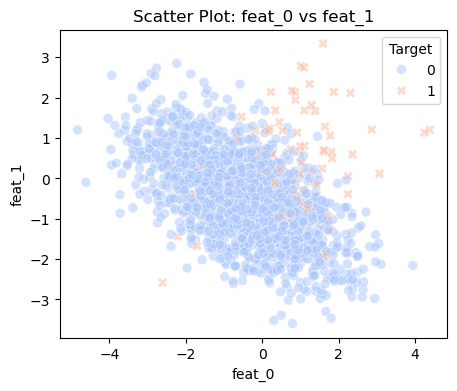

In [19]:
# Classes distribution feat_0 and feat_2
plot_features(df, 'feat_0', 'feat_1')

**IR = 18.05**

Class 0 (majority class) dominates a class 1 (minority class). This imbalance, combined with overlapping data points where both classes share similar feature values, makes distinguishing between them challenging. The model must handle not only the classes imbalance but also the lack of clear boundaries in the dataset space.

## 2. Building a model
This model will be a used to assess diffrent techniques of the imbalanaced data handling. 

I that case I chose a **Random Forest Classifier** as an example.

I will use basic performance metrics to compare various approaches, as follows:


- **Accurary:** $ACC = \frac{TP + TN}{P + N}$

- **Precision:** $Prec = \frac{TP}{PP}$

- **Recall:** $TP = \frac{TP}{P}$

- **F1:** $F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

In [25]:
# Splitting data into Training and Test set: 70/30%
X, y = split_data(df,'Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [27]:
# Exploring Training and Test sets
# Characteristics of the Training Set
print("Training Set Class Distribution:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the training set: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50)
# Characteristics of the Test Set
print("Testing Set Class Distribution:\n", y_test.value_counts(),'\n')
print("Proportion of Class 1 samples in the test set: ", round(y_test.value_counts()[1]/len(y_test)*100, 1))

Training Set Class Distribution:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the training set:  5.4 

--------------------------------------------------
Testing Set Class Distribution:
 Target
0    570
1     30
Name: count, dtype: int64 

Proportion of Class 1 samples in the test set:  5.0


- The **training set** contains **75 minority** class examples and **1325 majority** class examples
- The **test set** contains **30 minority** class examples and **570** majority class examples

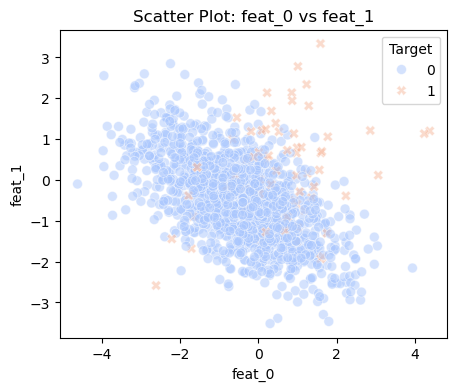

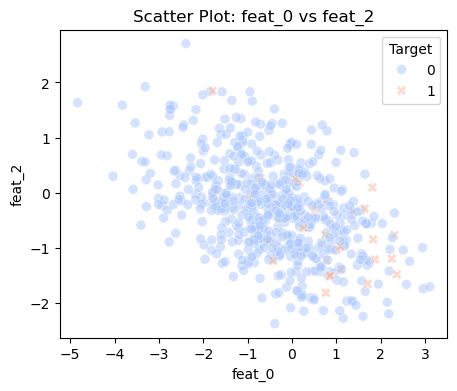

In [30]:
# Visualize Training and Test setts
df_train = pd.concat([X_train, y_train], axis=1)
df_train = df_train.reset_index(drop=True)

df_test = pd.concat([X_test, y_test], axis=1)
df_test = df_test.reset_index(drop=True)

# Plotting Training set
plot_features(df_train, 'feat_0', 'feat_1')
# Plotting Test set
plot_features(df_test, 'feat_0', 'feat_2')

In [32]:
# Model build and training
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       570
           1       0.87      0.43      0.58        30

    accuracy                           0.97       600
   macro avg       0.92      0.71      0.78       600
weighted avg       0.97      0.97      0.96       600



In [34]:
# Model performance
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

Accuracy: 0.97
Precision: 0.87
Recall: 0.43
F1 Score: 0.58


- Accuracy - model correctly classifies 97% of all instances, but it's misleading due to class imbalance.
- Precision - model predicts the minority class, it is correct 87% of the time.
- Recall - model only identifies 43% of all real instances of the minority class.
- F1 Score - a moderate balance between precision and recall, but model struggles to effectively identify the minority class.

## 3. Oversampling and Undersampling techniques

In this step I will use the **imbalanced-learn** library to fix dataset imbalance using the most popular approaches.

In [116]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [42]:
# Undersampling
def random_undersampling(X, y):
    generator = RandomUnderSampler(random_state=42)
    X_us, y_us = generator.fit_resample(X, y)
    df_us = pd.concat([X_us, y_us], axis=1)
    df_us = df_us.reset_index(drop=True)
    return X_us, y_us, df_us

# Oversampling
def random_oversampling(X, y):
    generator = RandomOverSampler(random_state=42)
    X_os, y_os = generator.fit_resample(X, y)
    df_os = pd.concat([X_os, y_os], axis=1)
    df_os = df_os.reset_index(drop=True)
    return X_os, y_os, df_os

# SMOTE (basic) 
def smote_oversampling(X, y, k=5):
    generator = SMOTE(random_state=42, k_neighbors=k)
    X_sm, y_sm = generator.fit_resample(X, y)
    df_sm = pd.concat([X_sm, y_sm], axis=1)
    df_sm = df_sm.reset_index(drop=True)
    return X_sm, y_sm, df_sm

### 3.1 RandomUndersampling (RUS)

Training Set Class Distribution before RUS:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after RUS:
 Target
0    75
1    75
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



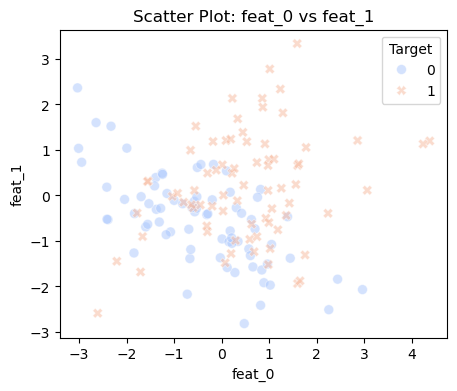

In [45]:
X_us, y_us, df_us = random_undersampling(X_train, y_train) # function for RUS

# Characteristics of the Training Set Before RUS
print("Training Set Class Distribution before RUS:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After RUS
print("Training Set Class Distribution after RUS:\n", y_us.value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(y_us.value_counts()[1]/len(y_us)*100, 1),'\n')
# Visualize dataset
plot_features(df_us, 'feat_0', 'feat_1')

In [47]:
# Model build and training
rf_model_us = RandomForestClassifier(random_state=42)
rf_model_us.fit(X_us, y_us)
y_pred = rf_model_us.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       570
           1       0.19      0.77      0.30        30

    accuracy                           0.82       600
   macro avg       0.59      0.79      0.60       600
weighted avg       0.95      0.82      0.87       600

Accuracy: 0.82
Precision: 0.19
Recall: 0.77
F1 Score: 0.30


### 3.2 RandomOversampling (ROS)

Training Set Class Distribution before ROS:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after ROS:
 Target
1    1325
0    1325
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



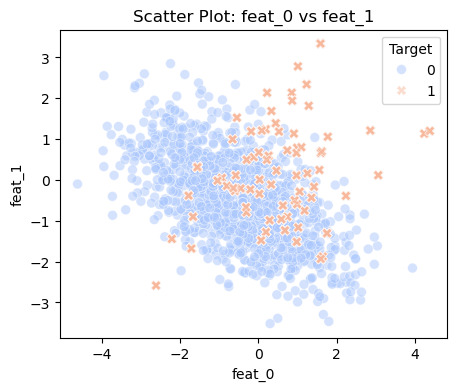

In [108]:
X_os, y_os, df_os = random_oversampling(X_train, y_train) # function for ROS

# Characteristics of the Training Set Before ROS
print("Training Set Class Distribution before ROS:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After ROS
print("Training Set Class Distribution after ROS:\n", y_os.value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(y_os.value_counts()[1]/len(y_os)*100, 1),'\n')
# Visualize dataset

plot_features(df_os, 'feat_0', 'feat_1')

In [52]:
# Model build and training
rf_model_os = RandomForestClassifier(random_state=42)
rf_model_os.fit(X_os, y_os)
y_pred = rf_model_os.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       570
           1       0.58      0.50      0.54        30

    accuracy                           0.96       600
   macro avg       0.78      0.74      0.76       600
weighted avg       0.95      0.96      0.96       600

Accuracy: 0.96
Precision: 0.58
Recall: 0.50
F1 Score: 0.54


### 3.3 SMOTE Basic

Training Set Class Distribution before ROS:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after ROS:
 Target
1    1325
0    1325
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



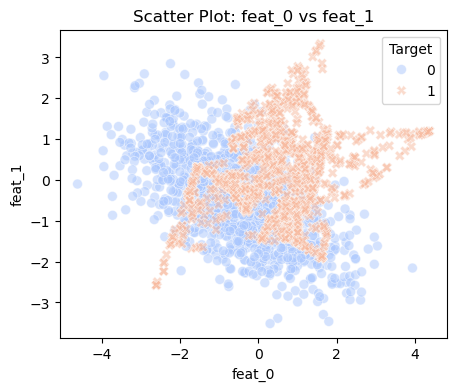

In [57]:
X_sm, y_sm, df_sm = smote_oversampling(X_train, y_train) # function for ROS

# Characteristics of the Training Set Before ROS
print("Training Set Class Distribution before ROS:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After ROS
print("Training Set Class Distribution after ROS:\n", y_sm.value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(y_sm.value_counts()[1]/len(y_sm)*100, 1),'\n')
# Visualize dataset
plot_features(df_sm, 'feat_0', 'feat_1')

In [59]:
# Model build and training
rf_model_sm = RandomForestClassifier(random_state=42)
rf_model_sm.fit(X_sm, y_sm)
y_pred = rf_model_sm.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       570
           1       0.30      0.67      0.42        30

    accuracy                           0.91       600
   macro avg       0.64      0.79      0.68       600
weighted avg       0.95      0.91      0.92       600

Accuracy: 0.91
Precision: 0.30
Recall: 0.67
F1 Score: 0.42


In next step of this point I will use **smote-variants** library to explore hybrid techniques to deal with imbalanced data.

This library contains various types of SMOTE oversampling techniques, in that case I will be focused on the following variants:
- **Borderline SMOTE**
- **SMOTE-TomekLinks**
- **SMOTE-ADASYN**
- **SMOTE-OUT**

In [62]:
from smote_variants import Borderline_SMOTE1, SMOTE_TomekLinks, ADASYN, SMOTE_OUT

In [64]:
# SMOTE Borderline
def smote_borderline(X, y):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    oversampler = Borderline_SMOTE1()
    X_bs, y_bs = oversampler.sample(X, y)
    X_bs = pd.DataFrame(X_bs, columns=X.columns if isinstance(X, pd.DataFrame) else None)
    y_bs = pd.Series(y_bs, name="Target")
    df_bs = pd.concat([X_bs, y_bs], axis=1)
    df_bs = df_bs.reset_index(drop=True)
    return X_bs, y_bs, df_bs

# SMOTE + TomekLinks
def smote_tomek(X, y):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    oversampler = SMOTE_TomekLinks()
    X_ts, y_ts = oversampler.sample(X, y)
    X_ts = pd.DataFrame(X_ts, columns=X.columns if isinstance(X, pd.DataFrame) else None)
    y_ts = pd.Series(y_ts, name="Target")
    df_ts = pd.concat([X_ts, y_ts], axis=1)
    df_ts = df_ts.reset_index(drop=True)
    return X_ts, y_ts, df_ts

# SMOTE ADASYN
def smote_adasyn(X, y):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    oversampler = ADASYN()
    X_as, y_as = oversampler.sample(X, y)
    X_as = pd.DataFrame(X_as, columns=X.columns if isinstance(X, pd.DataFrame) else None)
    y_as = pd.Series(y_as, name="Target")
    df_as = pd.concat([X_as, y_as], axis=1)
    df_as = df_as.reset_index(drop=True)
    return X_as, y_as, df_as


# SMOTE OUT
def smote_out(X, y):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    oversampler = SMOTE_OUT()
    X_ous, y_ous = oversampler.sample(X, y)
    X_ous = pd.DataFrame(X_ous, columns=X.columns if isinstance(X, pd.DataFrame) else None)
    y_ous = pd.Series(y_ous, name="Target")
    df_ous = pd.concat([X_ous, y_ous], axis=1)
    df_ous = df_bs.reset_index(drop=True)
    return X_ous, y_ous, df_ous

### 3.4 Borderline SMOTE

2024-11-25 15:31:22,266:INFO:Borderline_SMOTE1: Running sampling via ('Borderline_SMOTE1', "{'proportion': 1.0, 'n_neighbors': 5, 'k_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'Borderline_SMOTE1'}")
2024-11-25 15:31:22,271:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:31:22,274:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2024-11-25 15:31:22,282:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:31:22,283:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2024-11-25 15:31:22,286:INFO:Borderline_SMOTE1: simplex sampling with n_dim 2


Training Set Class Distribution before Borderline SMOTE:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after Borderline SMOTE:
 Target
1    1325
0    1325
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



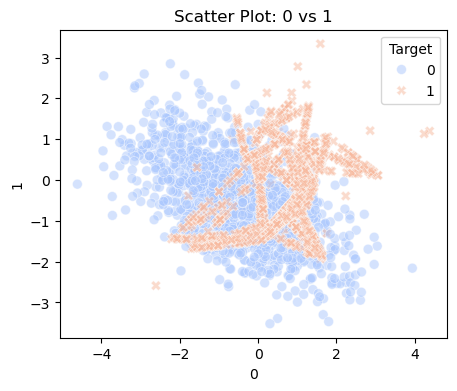

In [70]:
X_bs, y_bs, df_bs = smote_borderline(X_train, y_train) # function for SMOTE Borderline

# Characteristics of the Training Set Before SMOTE
print("Training Set Class Distribution before Borderline SMOTE:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After SMOTE
print("Training Set Class Distribution after Borderline SMOTE:\n", pd.Series(y_bs).value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(pd.Series(y_bs).value_counts()[1]/len(y_bs)*100, 1),'\n')
# Visualize dataset
plot_features(df_bs, 0, 1)

In [72]:
# Borderline SMOTE
# Model build and training
rf_model_bs = RandomForestClassifier(random_state=42)
rf_model_bs.fit(X_bs, y_bs)
y_pred = rf_model_bs.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       570
           1       0.39      0.57      0.46        30

    accuracy                           0.93       600
   macro avg       0.68      0.76      0.71       600
weighted avg       0.95      0.93      0.94       600

Accuracy: 0.93
Precision: 0.39
Recall: 0.57
F1 Score: 0.46


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### 3.4 Borderline TomekLinks

2024-11-25 15:33:23,218:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': None, 'class_name': 'SMOTE_TomekLinks'}")
2024-11-25 15:33:23,223:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2024-11-25 15:33:23,226:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:33:23,230:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2024-11-25 15:33:23,234:INFO:SMOTE: simplex sampling with n_dim 2
2024-11-25 15:33:23,243:INFO:TomekLinkRemoval: Running noise removal.
2024-11-25 15:33

Training Set Class Distribution before SMOTE + Tomek:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after SMOTE + Tomek:
 Target
1    1287
0    1287
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



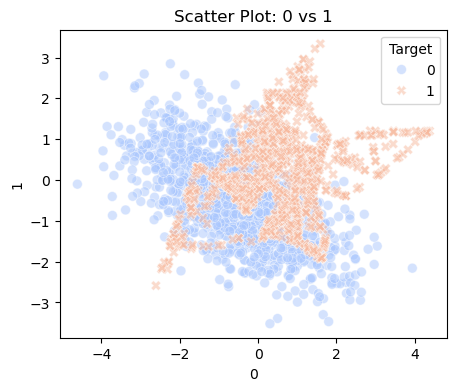

In [75]:
X_ts, y_ts, df_ts = smote_tomek(X_train, y_train) # function for SMOTE + Tomek

# Characteristics of the Training Set Before SMOTE
print("Training Set Class Distribution before SMOTE + Tomek:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After SMOTE
print("Training Set Class Distribution after SMOTE + Tomek:\n", pd.Series(y_ts).value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(pd.Series(y_ts).value_counts()[1]/len(y_ts)*100, 1),'\n')
# Visualize dataset
plot_features(df_ts, 0, 1)

In [77]:
# Smote + TomekLinks
# Model build and training
rf_model_ts = RandomForestClassifier(random_state=42)
rf_model_ts.fit(X_ts, y_ts)
y_pred = rf_model_ts.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       570
           1       0.25      0.67      0.36        30

    accuracy                           0.88       600
   macro avg       0.61      0.78      0.65       600
weighted avg       0.94      0.88      0.91       600

Accuracy: 0.88
Precision: 0.25
Recall: 0.67
F1 Score: 0.36


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### 3.6 SMOTE-ADASYN

2024-11-25 15:34:09,179:INFO:ADASYN: Running sampling via ('ADASYN', "{'n_neighbors': 5, 'd_th': 0.9, 'beta': 1.0, 'nn_params': {}, 'n_jobs': 1, 'proportion': 1.0, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'ADASYN'}")
2024-11-25 15:34:09,183:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:34:09,186:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2024-11-25 15:34:09,191:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:34:09,193:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2024-11-25 15:34:09,195:INFO:ADASYN: simplex sampling with n_dim 2


Training Set Class Distribution before SMOTE + ADASYN:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after SMOTE + ADASYN:
 Target
1    1325
0    1325
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



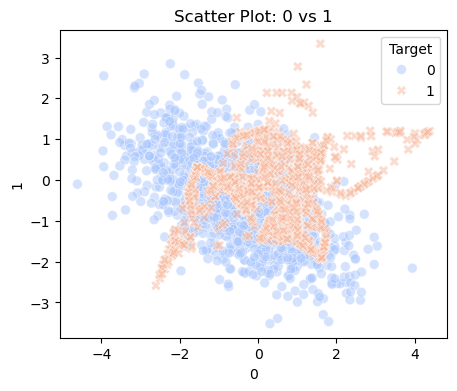

In [80]:
X_as, y_as, df_as = smote_adasyn(X_train, y_train) # function for SMOTE + ADASYN

# Characteristics of the Training Set Before SMOTE
print("Training Set Class Distribution before SMOTE + ADASYN:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After SMOTE
print("Training Set Class Distribution after SMOTE + ADASYN:\n", pd.Series(y_as).value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(pd.Series(y_as).value_counts()[1]/len(y_as)*100, 1),'\n')
# Visualize dataset
plot_features(df_as, 0, 1)

In [82]:
# Smote + ADASYN
# Model build and training
rf_model_as = RandomForestClassifier(random_state=42)
rf_model_as.fit(X_as, y_as)
y_pred = rf_model_as.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       570
           1       0.25      0.70      0.37        30

    accuracy                           0.88       600
   macro avg       0.62      0.79      0.65       600
weighted avg       0.95      0.88      0.91       600

Accuracy: 0.88
Precision: 0.25
Recall: 0.70
F1 Score: 0.37


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### 3.7 SMOTEOUT

2024-11-25 15:35:02,891:INFO:SMOTE_OUT: Running sampling via ('SMOTE_OUT', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': None, 'class_name': 'SMOTE_OUT'}")
2024-11-25 15:35:02,894:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:35:02,897:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2024-11-25 15:35:02,900:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-25 15:35:02,902:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Training Set Class Distribution before SMOTEOUT:
 Target
0    1325
1      75
Name: count, dtype: int64 

Proportion of Class 1 in the set before:  5.4 

-------------------------------------------------- 

Training Set Class Distribution after SMOTEOUT:
 Target
1    1325
0    1325
Name: count, dtype: int64 

Proportion of Class 1 samples in the set after:  50.0 



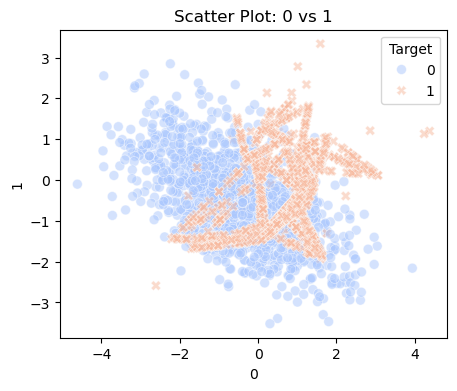

In [85]:
X_ous, y_ous, df_ous = smote_out(X_train, y_train) # function for SMOTEOUT

# Characteristics of the Training Set Before SMOTE
print("Training Set Class Distribution before SMOTEOUT:\n", y_train.value_counts(),'\n')
print("Proportion of Class 1 in the set before: ", round(y_train.value_counts()[1]/len(y_train)*100, 1),'\n')
print('-'*50, '\n')
# Characteristics of the Training Set After SMOTE
print("Training Set Class Distribution after SMOTEOUT:\n", pd.Series(y_ous).value_counts(),'\n')
print("Proportion of Class 1 samples in the set after: ", round(pd.Series(y_ous).value_counts()[1]/len(y_ous)*100, 1),'\n')
# Visualize dataset
plot_features(df_ous, 0, 1)

In [89]:
# SMOTEOUT
# Model build and training
rf_model_ous = RandomForestClassifier(random_state=42)
rf_model_ous.fit(X_ous, y_ous)
y_pred = rf_model_ous.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))
# Metrics
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       570
           1       0.29      0.70      0.41        30

    accuracy                           0.90       600
   macro avg       0.64      0.81      0.68       600
weighted avg       0.95      0.90      0.92       600

Accuracy: 0.90
Precision: 0.29
Recall: 0.70
F1 Score: 0.41


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Models metrics allows to

### 3.8 Random Forest with class weights
**The RandomForestClassifier** is created with the parameter **class_weight='balanced'**, which automatically adjusts class weights to give more importance to the minority class.

In [111]:
# Model build and training
rf_model_w = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model_w.fit(X_train, y_train)
y_pred = rf_model_w.predict(X_test)
# Classification report
print(classification_report(y_test, y_pred))
# Model performance
baseline_results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, pos_label=1),
    'Recall': recall_score(y_test, y_pred, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred, pos_label=1)
}
for metric, value in baseline_results.items():
    print(f'{metric}: {value:.2f}')

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       570
           1       0.92      0.40      0.56        30

    accuracy                           0.97       600
   macro avg       0.95      0.70      0.77       600
weighted avg       0.97      0.97      0.96       600

Accuracy: 0.97
Precision: 0.92
Recall: 0.40
F1 Score: 0.56


Not significant impact on the model performance using weights.